# Capstone
## *Show Me the Monet!*
### *Or how I learned to stop worrying, and apply neural networks to artistic recognition.*

The goal of the capstone was to generate a method for classifying Monet paintings versus other paintings present. Data that was used was for this analysis is stored on an s3 bucket  
  
The focus of this final project was to gain an understanding of neural networks that was not covered during my time at General Assembly. This required a large amount of learning with respect to neural networks and how they are used in image classification. 

To begin the project needed to decide what set up to use. Settled on Keras on top of theano. Had some experience with Theano from Daniel Nouri's fantastic [facial analysis](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/) work. Additional goals for the project were to determine what key features were identified by the model in classifying Monets versus other works. 

The stretch objective of this project was also to be able to use the neural network to create photos that have been manipulated to appear like works of Monet. This may require additional work following the end of the course. 

# Initial Image Exploration

To begin, it would be interesting to look at a few monet paintings to see how his early, middle, and late works differ. Through using the [opencv](http://opencv-python-tutroals.readthedocs.io/en/latest/index.html) package RGB histograms for an image of each period were constructed. 
The strategy for creating these histograms was to define a function that could be used for each of the images passed through it.

In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def rgb_hist(img_path, img_name):
    '''Function to Output Histogram from RGB Image'''
    img = img_path
    rgb = ('r', 'g', 'b')
    for pxl, colors in enumerate(rgb):
        rgb_hist= cv2.calcHist([cv2.imread(img)], [pxl], None, [256], [0,256])  # Look at images's pixels and categorize into colors
        plt.plot(rgb_hist, color=colors)                                        # Plot histogram, each color respective to the color present
        plt.xlim([0,256])
    plt.title("Color Histogram for " + str(img_name))
    plt.show()

The first image that was passed through this function was Monet's *La Gare Saint-Lazare*, which was painted in 1877. A relatively early painting by him, it shows his dedication to capturing the colors and motion that would come to define the impressionist movement. 
!["La Gare Saint-Lazare"](https://snag.gy/2Nm4XE.jpg)

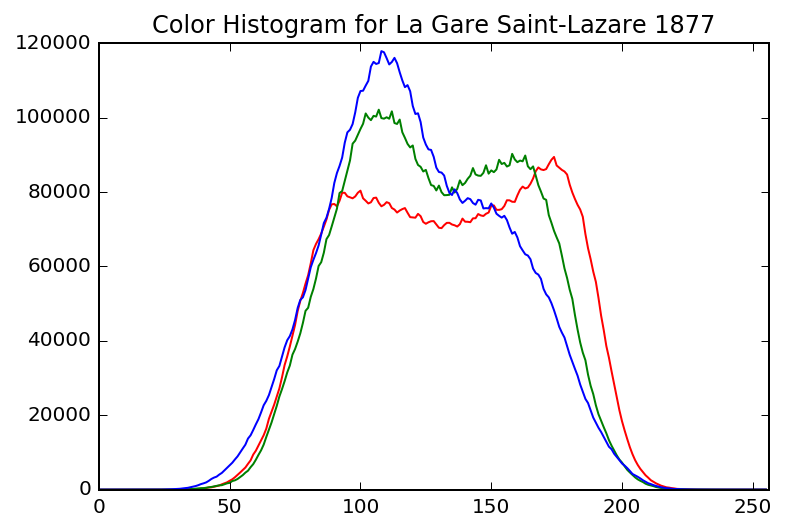

In [73]:
early = '/Users/sebozek/Desktop/Early - La Gare Saint-Lazare 1877.jpg'
name = 'La Gare Saint-Lazare 1877'
rgb_hist(early, name)

Second was one of Monet's Water Lilies. This painting was after his style had been refined and he was experimenting with more patoral scenes. This was still before the appearance of his cataracts. 
!["Water Lilies and Reflections of a Willow"](https://snag.gy/deqnpl.jpg)

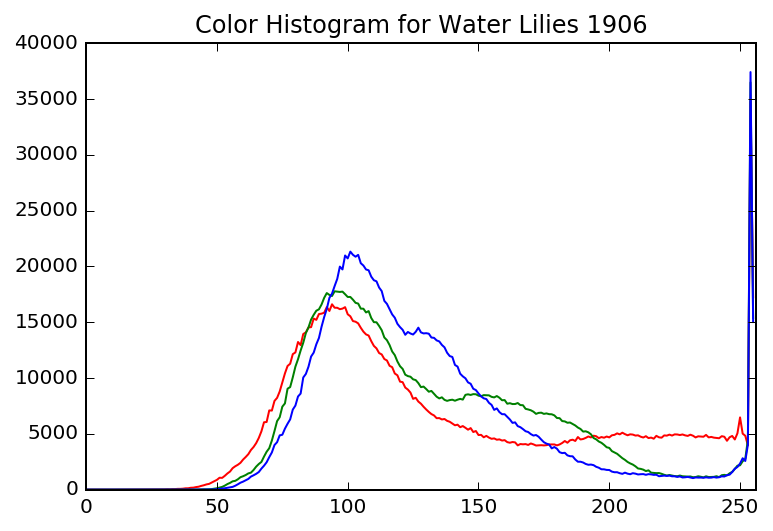

In [35]:
mid = '/Users/sebozek/Desktop/Mid - Water Lilies1906.jpg'
name = 'Water Lilies 1906'
rgb_hist(mid, name)

The final image here is another image of Water Lilies. Monet had cataracts when he painted this interpretation. The colors are certainly much more muted, and red has a much greater weight than the other colors, which is very typical of patients suffering from cataracts. 
!["Water Lilies and Reflections of a Willow"](https://snag.gy/1onP3m.jpg)

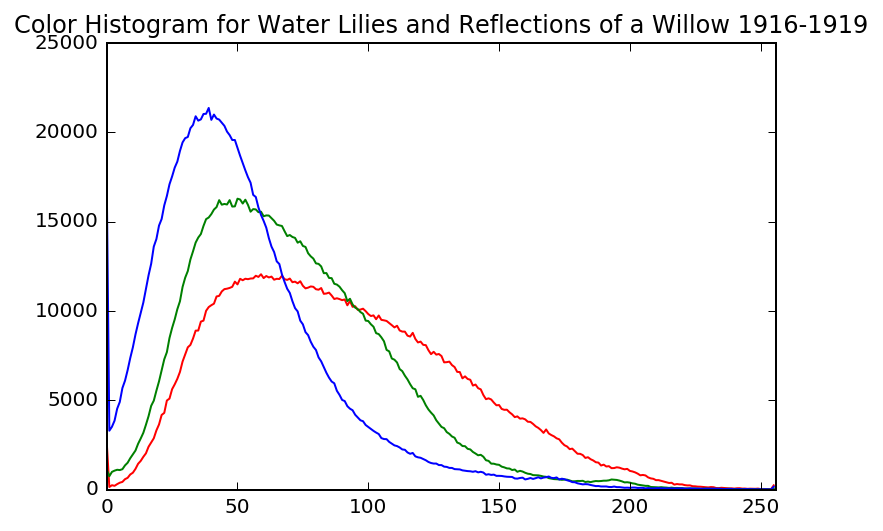

In [36]:
late = '/Users/sebozek/Desktop/Late - Water Lilies and Reflections of a Willow 1916-1919.jpg'
name = 'Water Lilies and Reflections of a Willow 1916-1919'
rgb_hist(late, name)

In [1]:
from keras.models import Sequential        # Linear stack of 'neurons'
import numpy as np


from keras.layers import (                 # Flattened list of layers
    
                          Convolution2D,   # Filters via windows of 2d input
                          MaxPooling2D,    # Subsets image into matrices, largest value of matrix is taken
                          Activation,      # Filters tha activate when deisred features are identified
    
                          Dropout,         # Prevents overfitting by dropping based on probability 1-p
                          Flatten,         # Layers comprising model graph
                          Dense            # Specify input argument shape
    
                          )

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN not available)


Below is a quick demonstration of how the image processing works. A photo that is fed through the below features will have a variety of transformations applied to it. 

In [71]:
# Data Cleaning and Preparation

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array,load_img
from keras.callbacks import History


d_gen = ImageDataGenerator( 
                            rotation_range=0.15,   # Random Roation within specified range
                            width_shift_range=0.15, # Horizontal shift as a fractional of image width
                            height_shift_range=0.15, # Vertical shift as fraction of image height
                            shear_range=0.15, # Intensity of shear
                            zoom_range=0.15, # Either number or list, but specifies the range for the random zoom
                            
            
                            fill_mode='nearest', # How pixels outside of the boundary are dealt with
                            horizontal_flip=True, # Random horizontal flip of sample
                            vertical_flip=True, # Random vertical flip of sample
                            rescale=1./225, # Scalar multiplying the image. 1 used  
#                             dim_ordering=K.image_dim_ordering()
                          )

In [72]:
monet1 = load_img('Claude_Monet,_Impression,_soleil_levant.jpg') # PIL image
monet_array = img_to_array(monet1) # Convert the 2d Image to an array
monet_array = monet_array.reshape((1,) + monet_array.shape) # Reshape to 1D

Show the purdy pictures.

In [73]:
# t = 0
# for batch in d_gen.flow(monet_array, batch_size=1,
#                         save_to_dir='mod', save_prefix='monet', 
#                         save_format='jpeg'):
#     t += 1
#     if t > 20: # Create 20 manipulated images
#         break 

# Creation of the Model

*Here is where the model is created. So far the model that is being used is a rather simple three step neural network. Then going to build out a bit more*

In [85]:


model = Sequential()

model.add(Convolution2D(32,3,3, input_shape=(3,150,150)))
model.add(Activation('relu'))
model.add(Dropout(0.2))  
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Convolution2D(64,2,2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(128,2,2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(256,3,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))




In [86]:

# model = Sequential()
# model.add(Convolution2D(32,3,3, input_shape=(3,100,100)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(3,3)))

# model.add(Convolution2D(64,3,3)
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(3,3)))
          
# model.add(Convolution2D(128,2,2))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# Build the model

In [87]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_24 (Convolution2D) (None, 32, 148, 148)  896         convolution2d_input_6[0][0]      
____________________________________________________________________________________________________
activation_24 (Activation)       (None, 32, 148, 148)  0           convolution2d_24[0][0]           
____________________________________________________________________________________________________
dropout_14 (Dropout)             (None, 32, 148, 148)  0           activation_24[0][0]              
____________________________________________________________________________________________________
maxpooling2d_24 (MaxPooling2D)   (None, 32, 49, 49)    0           dropout_14[0][0]                 
___________________________________________________________________________________________

In [88]:
model.add(Flatten())

model.add(Dense(256, activation='relu'))   # Rectified Linear Unit
model.add(Dropout(0.5))                 # Drop 50% of the Neurons
model.add(Dense(128, activation='sigmoid'))  # Yay, sigmoids
model.add(Dropout(0.5))                 # Drop 50% of the Neurons
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [89]:
# use the above datagen for training
d_gen = ImageDataGenerator(rescale=1./255,
                          shear_range=0.2,
                          zoom_range=0.2,
                          horizontal_flip=True)

# For test only use a rescale function
test_d_gen = ImageDataGenerator(rescale=1./255)

In [90]:
import numpy as np

monet_gen = d_gen.flow_from_directory('/home/sambozek/Desktop/Better_Data/Test/',       # Folder containing the test images
                                     target_size = (150, 150),              # Resize to 150 * 150 pxs
                                     batch_size = 25,                       # Reduce Noise, larger batch less noise
                                     class_mode='binary')                   # Binary Classification Problem

# bottleneck_features_train = model.predict_generator(monet_gen, 1500)
# np.save(open('bottleneck_features_train.npy', 'w'), bottleneck_features_train)

hold_out = d_gen.flow_from_directory('/home/sambozek/Desktop/Better_Data/Hold_Out/',
                                         target_size= (150, 150),
                                         batch_size = 25,
                                         class_mode='binary')

# bottleneck_features_validation = model.predict_generator(hold_out, 1000)
# np.save(open('bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)

Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


To avoid `Epoch comprised more than 'samples_per_epoch' samples` error need to make sure that batch size is divisible into 

In [97]:
from keras.callbacks import Callback

class TrainingHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.predictions = []
        self.i = 0
        self.save_every = 125

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.i += 1        
        if self.i % self.save_every == 0:        
            pred = model.predict(X_train)
            self.predictions.append(pred)
            
history = TrainingHistory()

In [98]:
model.fit_generator(monet_gen,                  # Resize the image get from test dictionary
                   samples_per_epoch=125,      # How many samples to use per epoch
                   nb_epoch=250,                 # Number of epochs used
                   validation_data = hold_out,  # Location of the validation data
                   nb_val_samples=250,          # Validation samples used per epoch
                   verbose=1,
                  callbacks=[history]
                   )

model.save_weights('monet_weights.h5', overwrite=True)

Epoch 1/250
125/125 [==============================] - 7s - loss: 0.0859 - acc: 0.9600 - val_loss: 0.4566 - val_acc: 0.8400
Epoch 2/250
125/125 [==============================] - 5s - loss: 0.0642 - acc: 0.9680 - val_loss: 0.9049 - val_acc: 0.7880
Epoch 3/250
125/125 [==============================] - 6s - loss: 0.2034 - acc: 0.9200 - val_loss: 0.4298 - val_acc: 0.8560
Epoch 4/250
125/125 [==============================] - 4s - loss: 0.1483 - acc: 0.9280 - val_loss: 0.6048 - val_acc: 0.7960
Epoch 5/250
125/125 [==============================] - 4s - loss: 0.1946 - acc: 0.9680 - val_loss: 0.6046 - val_acc: 0.8080
Epoch 6/250
125/125 [==============================] - 4s - loss: 0.1448 - acc: 0.9440 - val_loss: 0.6246 - val_acc: 0.7960
Epoch 7/250
125/125 [==============================] - 5s - loss: 0.1547 - acc: 0.9680 - val_loss: 0.4752 - val_acc: 0.8480
Epoch 8/250
125/125 [==============================] - 4s - loss: 0.2322 - acc: 0.8880 - val_loss: 0.6384 - val_acc: 0.8200
Epoch 9/

Exception: Error when checking : expected convolution2d_input_6 to have 4 dimensions, but got array with shape (1, 1)

In [ ]:
train_data = np.load(open('bottleneck_features_train.npy'))
# the features were saved in order, so recreating the labels is easy
train_labels = np.array([0] * 750 + [1] * 750)

validation_data = np.load(open('bottleneck_features_validation.npy'))
validation_labels = np.array([0] * 500 + [1] * 500)

model = Sequential()
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_data, train_labels,
          nb_epoch=2500, batch_size=32,
          validation_data=(validation_data, validation_labels))
model.save_weights('bottleneck_fc_model.h5')

In [33]:
from keras.utils.visualize_util import plot
import pydot
plot(model, show_shapes=True, to_file='model.png')

In [34]:
monet_model = model.to_json() # Save model to json

In [61]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import keras

class DrawWeights(keras.callbacks.Callback):

    def __init__(self, figsize, layer_id=0, param_id=0, weight_slice=(slice(None), 0)):
        self.layer_id = layer_id
        self.param_id = param_id
        self.weight_slice = weight_slice
        # Initialize the figure and axis
        self.fig = plt.figure(figsize=figsize)
        self.ax = self.fig.add_subplot(1, 1, 1)

    def on_train_begin(self):
        self.imgs = []

    def on_batch_end(self, batch, indices, loss, accuracy):
        # Get a snapshot of the weight matrix every 5 batches
        if batch % 5 == 0:
            # Access the full weight matrix
            weights = self.model.layers[self.layer_id].params[self.param_id].get_value()
            # Create the frame and add it to the animation
            img = self.ax.imshow(weights[self.weight_slice], interpolation='nearest')
            self.imgs.append(img)

    def on_train_end(self):
        # Once the training has ended, display the animation
        anim = animation.ArtistAnimation(self.fig, self.imgs, interval=10, blit=False)
        plt.show()

In [67]:
X_train = np.array(monet_gen, ndmin=2).T
Y_train = np.array(hold_out, ndmin=2).T

draw_weights = DrawWeights(figsize=(4, 4), layer_id=0, \
    param_id=0, weight_slice=(slice(None), 0))
model.fit(monet_gen, hold_out, batch_size=32, nb_epoch=15, \
    verbose=1, callbacks=[draw_weights])

Exception: Error when checking model input: data should be a Numpy array, or list/dict of Numpy arrays. Found: <keras.preprocessing.image.DirectoryIterator object at 0x7fd61b2a7cd0>...

* Test : 
    * Monet:
    * Not Monet:
* Hold Out: **No Issues**
    * Monet:
    * Not Monet:

*Initial running of the model found there was an issue with the image files and was given this error message:  
**IOError: image file is truncated (39 bytes not processed)**  
From [StackOverflow](http://bit.ly/21oXdhF) it was found that the images were likely corrupted or had unneeded trailing bytes. In order to find these truncated files used [jpeginfo](https://github.com/tjko/jpeginfo) to create a text file of the analysis of the jpegs. Output read by pandas allows for isolation of the trouble data.*


!jpeginfo -c *.jpg >> Test_monet.txt

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# test_monet = pd.read_csv("/Users/sebozek/Desktop/Test.txt",delim_whitespace=True,header=None)
# test_not_monet = pd.read_csv("/Users/sebozek/Desktop/Test.txt",delim_whitespace=True,header=None)
# val_monet = pd.read_csv("/Users/sebozek/Desktop/HoldOut.txt",delim_whitespace=True,header=None, error_bad_lines=False)
# val_not_monet = pd.read_csv("/Users/sebozek/Desktop/HoldOut_nm.txt", delim_whitespace=True, header=None,  error_bad_lines=False)

In [ ]:
# dfs = [test_monet, test_not_monet, val_monet, val_not_monet]

# # More Descriptive Labels
# for df in dfs:
#     df.columns = ["img_name", "width", "x", 'height', 'bits', 'format', 'N/P', 'pixels', 'test']

In [ ]:
# for df in dfs:
#     print df.test.unique()
    
# print val_not_monet.test.unique()

In [ ]:
# val_not_monet['img_name'][val_not_monet.test == '[ERROR]'].values

## To Do

* Validation
    * ROC curve
    * Confusion Matrix
* What does model think is important?
* Restricted Boltzmann Machine for Monet Replication